# Enable Agent Tutorial Part 3: Context Builder 구현

## 개요

Enable Agent의 예측 결과를 저장하고 지식 베이스로 변환한다. Context Builder는 모든 예측을 기록하고 RAG를 위한 컨텍스트를 준비한다.


## 학습 내용

- 예측 결과 저장 및 관리
- 통계 요약 자동 생성
- 자연어 지식 베이스 구축
- RAG를 위한 컨텍스트 준비

---
## 1. 라이브러리 임포트

In [1]:
import json
import os
import yaml
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import List, Dict, Any, Tuple
from pathlib import Path

import torch
import torch.nn as nn

from dotenv import load_dotenv
from openai import OpenAI

In [2]:
load_dotenv()

True

---
## 2. PredictionContextBuilder 클래스 구현

### 주요 기능

- `add_prediction()`: 새로운 예측 결과 추가
- `_update_summary()`: 통계 요약 자동 갱신
- `_update_knowledge_base()`: 자연어 지식 베이스 갱신
- `get_summary()`: 요약 정보 조회
- `get_knowledge_base_content()`: 지식 베이스 조회

In [3]:
class PredictionContextBuilder:
    """예측 결과를 컨텍스트로 저장하고 관리하는 클래스"""
    
    def __init__(self, context_dir: str = 'context_store'):
        self.context_dir = Path(context_dir)
        self.context_dir.mkdir(exist_ok=True)
        
        self.log_file = self.context_dir / 'prediction_logs.json'
        self.summary_file = self.context_dir / 'prediction_summary.json'
        self.knowledge_base_file = self.context_dir / 'knowledge_base.txt'
        
        self.logs = self._load_logs()
        
        print(f"Context Builder 초기화 완료")
        print(f"저장된 예측 로그: {len(self.logs)}개")
    
    def _load_logs(self) -> List[Dict[str, Any]]:
        if self.log_file.exists():
            with open(self.log_file, 'r', encoding='utf-8') as f:
                return json.load(f)
        return []
    
    def add_prediction(self, prediction_result: Dict[str, Any]):
        self.logs.append(prediction_result)
        
        with open(self.log_file, 'w', encoding='utf-8') as f:
            json.dump(self.logs, f, indent=2, ensure_ascii=False)
        
        print(f"예측 결과 저장 완료 (총 {len(self.logs)}개)")
        
        self._update_summary()
        self._update_knowledge_base()
    
    def _update_summary(self):
        if not self.logs:
            return
        
        total_predictions = len(self.logs)
        
        class_counts = {'Transported': 0, 'Not Transported': 0}
        probability_sum = 0
        confidence_sum = 0
        
        age_values = []
        spending_values = {'RoomService': [], 'FoodCourt': [], 'ShoppingMall': [], 'Spa': [], 'VRDeck': []}
        homeplanet_counts = {}
        cryosleep_counts = {0: 0, 1: 0}
        
        for log in self.logs:
            predicted_class = log['predicted_class']
            class_counts[predicted_class] = class_counts.get(predicted_class, 0) + 1
            probability_sum += log['probability']
            confidence_sum += log['confidence']
            
            features = log['input_features']
            age_values.append(features['Age'])
            
            for spending_key in spending_values.keys():
                spending_values[spending_key].append(features[spending_key])
            
            hp = features['HomePlanet']
            homeplanet_counts[hp] = homeplanet_counts.get(hp, 0) + 1
            cryosleep_counts[features['CryoSleep']] += 1
        
        avg_probability = probability_sum / total_predictions
        avg_confidence = confidence_sum / total_predictions
        avg_age = sum(age_values) / len(age_values)
        
        spending_averages = {k: sum(v) / len(v) for k, v in spending_values.items()}
        total_spending_avg = sum(spending_averages.values())
        
        summary = {
            "total_predictions": total_predictions,
            "class_distribution": class_counts,
            "average_probability": avg_probability,
            "average_confidence": avg_confidence,
            "average_age": avg_age,
            "spending_averages": spending_averages,
            "total_spending_average": total_spending_avg,
            "homeplanet_distribution": homeplanet_counts,
            "cryosleep_distribution": cryosleep_counts,
            "last_updated": datetime.now().isoformat()
        }
        
        with open(self.summary_file, 'w', encoding='utf-8') as f:
            json.dump(summary, f, indent=2, ensure_ascii=False)
    
    def _update_knowledge_base(self):
        if not self.logs:
            return
        
        with open(self.summary_file, 'r', encoding='utf-8') as f:
            summary = json.load(f)
        
        homeplanet_map = {0: 'Earth', 1: 'Europa', 2: 'Mars', 3: 'Unknown'}
        
        knowledge_text = f"""# Spaceship Titanic 예측 지식 베이스

## 전체 통계 (마지막 업데이트: {summary['last_updated']})

총 예측 수행 횟수: {summary['total_predictions']}회
평균 이동 확률: {summary['average_probability']:.2%}
평균 예측 신뢰도: {summary['average_confidence']:.2%}

## 예측 결과 분포

"""
        
        for cls, count in summary['class_distribution'].items():
            percentage = (count / summary['total_predictions']) * 100
            knowledge_text += f"- {cls}: {count}회 ({percentage:.1f}%)\n"
        
        knowledge_text += f"\n## 승객 특성 통계\n\n"
        knowledge_text += f"- 평균 나이: {summary['average_age']:.1f}세\n"
        knowledge_text += f"- 평균 총 지출: {summary['total_spending_average']:.1f}\n\n"
        
        knowledge_text += f"### 지출 항목별 평균\n\n"
        for item, avg in summary['spending_averages'].items():
            knowledge_text += f"- {item}: {avg:.1f}\n"
        
        knowledge_text += f"\n### 출발 행성 분포\n\n"
        for hp, count in summary['homeplanet_distribution'].items():
            planet_name = homeplanet_map.get(int(hp), 'Unknown')
            knowledge_text += f"- {planet_name}: {count}회\n"
        
        knowledge_text += f"\n### 냉동 수면 분포\n\n"
        knowledge_text += f"- 냉동 수면 O: {summary['cryosleep_distribution'].get('1', summary['cryosleep_distribution'].get(1, 0))}회\n"
        knowledge_text += f"- 냉동 수면 X: {summary['cryosleep_distribution'].get('0', summary['cryosleep_distribution'].get(0, 0))}회\n"
        
        knowledge_text += "\n## 최근 예측 기록 (최근 10개)\n\n"
        
        recent_logs = self.logs[-10:]
        for i, log in enumerate(reversed(recent_logs), 1):
            decoded = log.get('decoded_features', log['input_features'])
            knowledge_text += f"""### 예측 #{len(self.logs) - i + 1}

- 예측 결과: {log['predicted_class']}
- 이동 확률: {log['probability']:.2%}
- 신뢰도: {log['confidence']:.2%}
- 출발 행성: {decoded.get('HomePlanet', log['input_features']['HomePlanet'])}
- 냉동 수면: {decoded.get('CryoSleep', log['input_features']['CryoSleep'])}
- 나이: {log['input_features']['Age']}세

"""
        
        with open(self.knowledge_base_file, 'w', encoding='utf-8') as f:
            f.write(knowledge_text.strip())
    
    def get_knowledge_base_content(self) -> str:
        if self.knowledge_base_file.exists():
            with open(self.knowledge_base_file, 'r', encoding='utf-8') as f:
                return f.read()
        return ""
    
    def get_summary(self) -> Dict[str, Any]:
        if self.summary_file.exists():
            with open(self.summary_file, 'r', encoding='utf-8') as f:
                return json.load(f)
        return {}
    
    def clear_logs(self):
        self.logs = []
        for file in [self.log_file, self.summary_file, self.knowledge_base_file]:
            if file.exists():
                file.unlink()
        print("로그 초기화 완료")

print("PredictionContextBuilder 클래스 정의 완료")

PredictionContextBuilder 클래스 정의 완료


---
## 3. Context Builder 초기화

In [4]:
context_builder = PredictionContextBuilder()

existing_summary = context_builder.get_summary()
if existing_summary:
    print("\n기존 예측 통계:")
    print(json.dumps(existing_summary, indent=2, ensure_ascii=False))
else:
    print("\n새로운 컨텍스트 저장소가 생성되었다.")

Context Builder 초기화 완료
저장된 예측 로그: 0개

새로운 컨텍스트 저장소가 생성되었다.


---
## 4. SpaceshipEnableAgent 클래스 (Part 2에서 재사용)

In [5]:
class SpaceshipClassifier(nn.Module):
    """Spaceship Titanic 이진 분류 신경망"""
    
    def __init__(self, input_dim=10, hidden_dims=[64, 32, 16], dropout_rate=0.3):
        super(SpaceshipClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            if i < len(hidden_dims) - 1:
                layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()


class SpaceshipEnableAgent:
    """Spaceship Titanic 예측 모델을 Enable Agent로 래핑한 클래스"""
    
    def __init__(self, skill_path: str):
        with open(skill_path, 'r', encoding='utf-8') as f:
            self.skill = yaml.safe_load(f)
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        model_path = self.skill['model_info']['model_path']
        checkpoint = torch.load(model_path, map_location=self.device, weights_only=True)
        
        self.model = SpaceshipClassifier(
            input_dim=checkpoint['input_dim'],
            hidden_dims=checkpoint['hidden_dims'],
            dropout_rate=checkpoint['dropout_rate']
        ).to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        scaler_path = self.skill['model_info']['scaler_path']
        self.scaler = joblib.load(scaler_path)
        
        metadata_path = self.skill['model_info']['metadata_path']
        with open(metadata_path, 'r', encoding='utf-8') as f:
            self.metadata = json.load(f)
        
        self.encoding_maps = self.skill['encoding_maps']
        self.client = OpenAI()
        
        print(f"Enable Agent 초기화 완료: {self.skill['agent_name']}")
    
    def _decode_categorical(self, input_data: Dict[str, Any]) -> Dict[str, str]:
        decoded = {}
        for field, value in input_data.items():
            if field in self.encoding_maps:
                decoded[field] = self.encoding_maps[field].get(value, str(value))
            else:
                decoded[field] = value
        return decoded
    
    def predict(self, input_data: Dict[str, Any]) -> Dict[str, Any]:
        feature_names = self.metadata['feature_names']
        input_array = np.array([[input_data[f] for f in feature_names]])
        
        input_scaled = self.scaler.transform(input_array)
        input_tensor = torch.FloatTensor(input_scaled).to(self.device)
        
        with torch.no_grad():
            probability = self.model(input_tensor).item()
        
        predicted_class = 'Transported' if probability > 0.5 else 'Not Transported'
        confidence = probability if probability > 0.5 else (1 - probability)
        
        decoded_features = self._decode_categorical(input_data)
        
        return {
            "predicted_class": predicted_class,
            "probability": float(probability),
            "confidence": float(confidence),
            "input_features": input_data,
            "decoded_features": decoded_features,
            "timestamp": datetime.now().isoformat()
        }

print("SpaceshipEnableAgent 클래스 정의 완료")

SpaceshipEnableAgent 클래스 정의 완료


---
## 5. 예측 수행 및 컨텍스트 저장

In [6]:
agent = SpaceshipEnableAgent('skills/spaceship_agent_skill.yaml')

Enable Agent 초기화 완료: SpaceshipTransportPredictor


In [7]:
# 기존 로그 초기화 (선택사항)
context_builder.clear_logs()

로그 초기화 완료


In [8]:
test_samples = [
    # 냉동 수면 승객들 (이동 가능성 높음)
    {'HomePlanet': 0, 'CryoSleep': 1, 'Destination': 2, 'Age': 25.0, 'VIP': 0,
     'RoomService': 0.0, 'FoodCourt': 0.0, 'ShoppingMall': 0.0, 'Spa': 0.0, 'VRDeck': 0.0},
    {'HomePlanet': 1, 'CryoSleep': 1, 'Destination': 0, 'Age': 35.0, 'VIP': 0,
     'RoomService': 0.0, 'FoodCourt': 0.0, 'ShoppingMall': 0.0, 'Spa': 0.0, 'VRDeck': 0.0},
    {'HomePlanet': 2, 'CryoSleep': 1, 'Destination': 1, 'Age': 45.0, 'VIP': 0,
     'RoomService': 0.0, 'FoodCourt': 0.0, 'ShoppingMall': 0.0, 'Spa': 0.0, 'VRDeck': 0.0},
    
    # 고지출 승객들 (이동 가능성 낮음)
    {'HomePlanet': 0, 'CryoSleep': 0, 'Destination': 2, 'Age': 40.0, 'VIP': 1,
     'RoomService': 1500.0, 'FoodCourt': 2000.0, 'ShoppingMall': 800.0, 'Spa': 3000.0, 'VRDeck': 1200.0},
    {'HomePlanet': 1, 'CryoSleep': 0, 'Destination': 0, 'Age': 55.0, 'VIP': 1,
     'RoomService': 2500.0, 'FoodCourt': 1500.0, 'ShoppingMall': 1200.0, 'Spa': 4000.0, 'VRDeck': 2000.0},
    
    # 저지출 비냉동 수면 승객들
    {'HomePlanet': 0, 'CryoSleep': 0, 'Destination': 2, 'Age': 22.0, 'VIP': 0,
     'RoomService': 50.0, 'FoodCourt': 100.0, 'ShoppingMall': 30.0, 'Spa': 0.0, 'VRDeck': 200.0},
    {'HomePlanet': 2, 'CryoSleep': 0, 'Destination': 1, 'Age': 30.0, 'VIP': 0,
     'RoomService': 0.0, 'FoodCourt': 500.0, 'ShoppingMall': 100.0, 'Spa': 200.0, 'VRDeck': 0.0},
    
    # 다양한 연령대
    {'HomePlanet': 0, 'CryoSleep': 1, 'Destination': 2, 'Age': 8.0, 'VIP': 0,
     'RoomService': 0.0, 'FoodCourt': 0.0, 'ShoppingMall': 0.0, 'Spa': 0.0, 'VRDeck': 0.0},
    {'HomePlanet': 1, 'CryoSleep': 0, 'Destination': 0, 'Age': 70.0, 'VIP': 1,
     'RoomService': 800.0, 'FoodCourt': 300.0, 'ShoppingMall': 200.0, 'Spa': 1500.0, 'VRDeck': 100.0},
    {'HomePlanet': 0, 'CryoSleep': 0, 'Destination': 2, 'Age': 18.0, 'VIP': 0,
     'RoomService': 100.0, 'FoodCourt': 800.0, 'ShoppingMall': 500.0, 'Spa': 0.0, 'VRDeck': 1500.0},
]

print("=== 예측 수행 및 컨텍스트 저장 ===")
print()

results = []
for i, sample in enumerate(test_samples, 1):
    print(f"[{i}/{len(test_samples)}] 예측 수행 중...")
    result = agent.predict(sample)
    context_builder.add_prediction(result)
    results.append(result)
    print(f"  -> {result['predicted_class']} (확률: {result['probability']:.2%})")
    print()

=== 예측 수행 및 컨텍스트 저장 ===

[1/10] 예측 수행 중...
예측 결과 저장 완료 (총 1개)
  -> Transported (확률: 66.66%)

[2/10] 예측 수행 중...
예측 결과 저장 완료 (총 2개)
  -> Transported (확률: 99.22%)

[3/10] 예측 수행 중...
예측 결과 저장 완료 (총 3개)
  -> Transported (확률: 91.41%)

[4/10] 예측 수행 중...
예측 결과 저장 완료 (총 4개)
  -> Not Transported (확률: 0.47%)

[5/10] 예측 수행 중...
예측 결과 저장 완료 (총 5개)
  -> Not Transported (확률: 0.05%)

[6/10] 예측 수행 중...
예측 결과 저장 완료 (총 6개)
  -> Not Transported (확률: 20.62%)

[7/10] 예측 수행 중...
예측 결과 저장 완료 (총 7개)
  -> Not Transported (확률: 35.02%)

[8/10] 예측 수행 중...
예측 결과 저장 완료 (총 8개)
  -> Transported (확률: 67.56%)

[9/10] 예측 수행 중...
예측 결과 저장 완료 (총 9개)
  -> Not Transported (확률: 12.71%)

[10/10] 예측 수행 중...
예측 결과 저장 완료 (총 10개)
  -> Not Transported (확률: 11.12%)



---
## 6. 통계 요약 분석

In [9]:
summary = context_builder.get_summary()

print("=== 예측 통계 요약 ===")
print(json.dumps(summary, indent=2, ensure_ascii=False))

=== 예측 통계 요약 ===
{
  "total_predictions": 10,
  "class_distribution": {
    "Transported": 4,
    "Not Transported": 6
  },
  "average_probability": 0.4048292164807208,
  "average_confidence": 0.8448617572779767,
  "average_age": 34.8,
  "spending_averages": {
    "RoomService": 495.0,
    "FoodCourt": 520.0,
    "ShoppingMall": 283.0,
    "Spa": 870.0,
    "VRDeck": 500.0
  },
  "total_spending_average": 2668.0,
  "homeplanet_distribution": {
    "0": 5,
    "1": 3,
    "2": 2
  },
  "cryosleep_distribution": {
    "0": 6,
    "1": 4
  },
  "last_updated": "2025-12-16T18:14:47.498563"
}


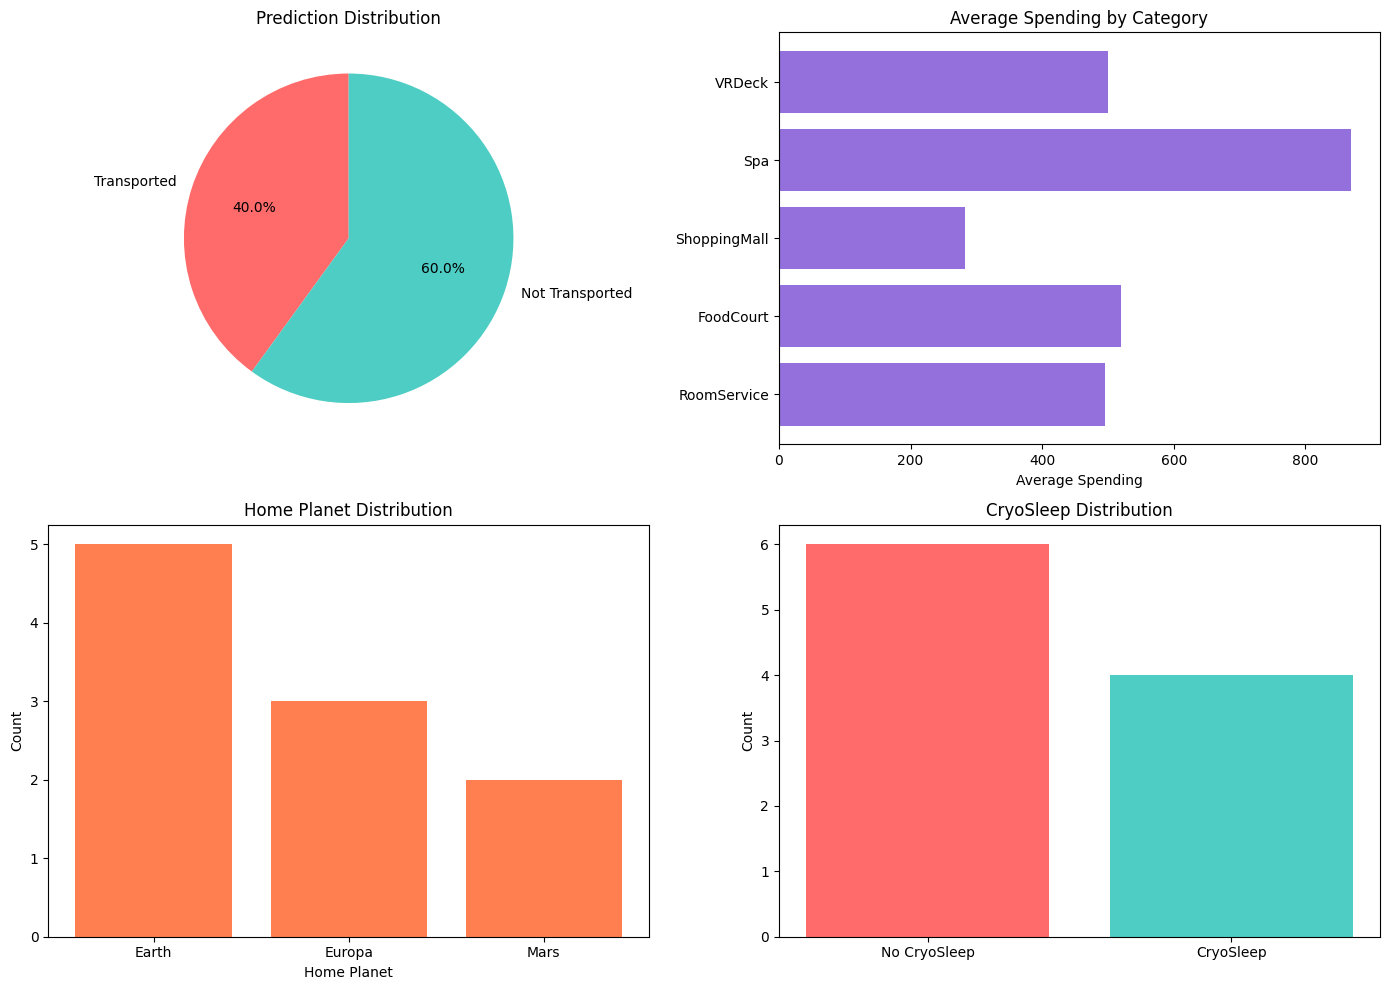

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 예측 결과 분포
ax = axes[0, 0]
classes = list(summary['class_distribution'].keys())
counts = list(summary['class_distribution'].values())
colors = ['#ff6b6b', '#4ecdc4']
ax.pie(counts, labels=classes, autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('Prediction Distribution')

# 지출 항목별 평균
ax = axes[0, 1]
spending_items = list(summary['spending_averages'].keys())
spending_values = list(summary['spending_averages'].values())
ax.barh(spending_items, spending_values, color='mediumpurple')
ax.set_xlabel('Average Spending')
ax.set_title('Average Spending by Category')

# 출발 행성 분포
ax = axes[1, 0]
homeplanet_map = {0: 'Earth', 1: 'Europa', 2: 'Mars', 3: 'Unknown'}
planets = [homeplanet_map[int(k)] for k in summary['homeplanet_distribution'].keys()]
planet_counts = list(summary['homeplanet_distribution'].values())
ax.bar(planets, planet_counts, color='coral')
ax.set_xlabel('Home Planet')
ax.set_ylabel('Count')
ax.set_title('Home Planet Distribution')

# 냉동 수면 분포
ax = axes[1, 1]
cryo_labels = ['No CryoSleep', 'CryoSleep']
cryo_counts = [summary['cryosleep_distribution'].get('0', summary['cryosleep_distribution'].get(0, 0)),
               summary['cryosleep_distribution'].get('1', summary['cryosleep_distribution'].get(1, 0))]
ax.bar(cryo_labels, cryo_counts, color=['#ff6b6b', '#4ecdc4'])
ax.set_ylabel('Count')
ax.set_title('CryoSleep Distribution')

plt.tight_layout()
plt.show()

---
## 7. 지식 베이스 확인

In [11]:
knowledge_base = context_builder.get_knowledge_base_content()

print("=== 지식 베이스 내용 ===")
print(knowledge_base[:3000])
print("\n... (이하 생략)")

=== 지식 베이스 내용 ===
# Spaceship Titanic 예측 지식 베이스

## 전체 통계 (마지막 업데이트: 2025-12-16T18:14:47.498563)

총 예측 수행 횟수: 10회
평균 이동 확률: 40.48%
평균 예측 신뢰도: 84.49%

## 예측 결과 분포

- Transported: 4회 (40.0%)
- Not Transported: 6회 (60.0%)

## 승객 특성 통계

- 평균 나이: 34.8세
- 평균 총 지출: 2668.0

### 지출 항목별 평균

- RoomService: 495.0
- FoodCourt: 520.0
- ShoppingMall: 283.0
- Spa: 870.0
- VRDeck: 500.0

### 출발 행성 분포

- Earth: 5회
- Europa: 3회
- Mars: 2회

### 냉동 수면 분포

- 냉동 수면 O: 4회
- 냉동 수면 X: 6회

## 최근 예측 기록 (최근 10개)

### 예측 #10

- 예측 결과: Not Transported
- 이동 확률: 11.12%
- 신뢰도: 88.88%
- 출발 행성: Earth
- 냉동 수면: No
- 나이: 18.0세

### 예측 #9

- 예측 결과: Not Transported
- 이동 확률: 12.71%
- 신뢰도: 87.29%
- 출발 행성: Europa
- 냉동 수면: No
- 나이: 70.0세

### 예측 #8

- 예측 결과: Transported
- 이동 확률: 67.56%
- 신뢰도: 67.56%
- 출발 행성: Earth
- 냉동 수면: Yes
- 나이: 8.0세

### 예측 #7

- 예측 결과: Not Transported
- 이동 확률: 35.02%
- 신뢰도: 64.98%
- 출발 행성: Mars
- 냉동 수면: No
- 나이: 30.0세

### 예측 #6

- 예측 결과: Not Transported
- 이동 확률: 20.62%
- 신뢰도: 79.38%
- 출발 행성: Earth
- 냉동 수면:

---
## 8. 예측 로그 분석

In [12]:
df_logs = pd.DataFrame([
    {
        'timestamp': log['timestamp'],
        'predicted_class': log['predicted_class'],
        'probability': log['probability'],
        'confidence': log['confidence'],
        'HomePlanet': log['decoded_features']['HomePlanet'],
        'CryoSleep': log['decoded_features']['CryoSleep'],
        'Age': log['input_features']['Age'],
        'TotalSpending': sum([
            log['input_features']['RoomService'],
            log['input_features']['FoodCourt'],
            log['input_features']['ShoppingMall'],
            log['input_features']['Spa'],
            log['input_features']['VRDeck']
        ])
    }
    for log in context_builder.logs
])

print("=== 예측 로그 DataFrame ===")
df_logs

=== 예측 로그 DataFrame ===


,timestamp,predicted_class,probability,confidence,HomePlanet,CryoSleep,Age,TotalSpending
0,2025-12-16T18:14:47.486434,Transported,0.666551,0.666551,Earth,Yes,25.0,0.0
1,2025-12-16T18:14:47.487850,Transported,0.992192,0.992192,Europa,Yes,35.0,0.0
2,2025-12-16T18:14:47.489113,Transported,0.914123,0.914123,Mars,Yes,45.0,0.0
3,2025-12-16T18:14:47.490602,Not Transported,0.004685,0.995315,Earth,No,40.0,8500.0
4,2025-12-16T18:14:47.492086,Not Transported,0.000530,0.999470,Europa,No,55.0,11200.0
5,2025-12-16T18:14:47.493278,Not Transported,0.206168,0.793832,Earth,No,22.0,380.0
6,2025-12-16T18:14:47.494430,Not Transported,0.350168,0.649832,Mars,No,30.0,800.0
7,2025-12-16T18:14:47.495497,Transported,0.675589,0.675589,Earth,Yes,8.0,0.0
8,2025-12-16T18:14:47.496887,Not Transported,0.127052,0.872948,Europa,No,70.0,2900.0
9,2025-12-16T18:14:47.498027,Not Transported,0.111235,0.888765,Earth,No,18.0,2900.0


In [13]:
print("=== 예측 결과별 통계 ===")
df_logs.groupby('predicted_class').agg({
    'probability': ['mean', 'min', 'max'],
    'Age': 'mean',
    'TotalSpending': 'mean'
}).round(2)

=== 예측 결과별 통계 ===


probability                Age TotalSpending
                       mean   min   max   mean          mean
predicted_class                                             
Not Transported        0.13  0.00  0.35  39.17       4446.67
Transported            0.81  0.67  0.99  28.25          0.00

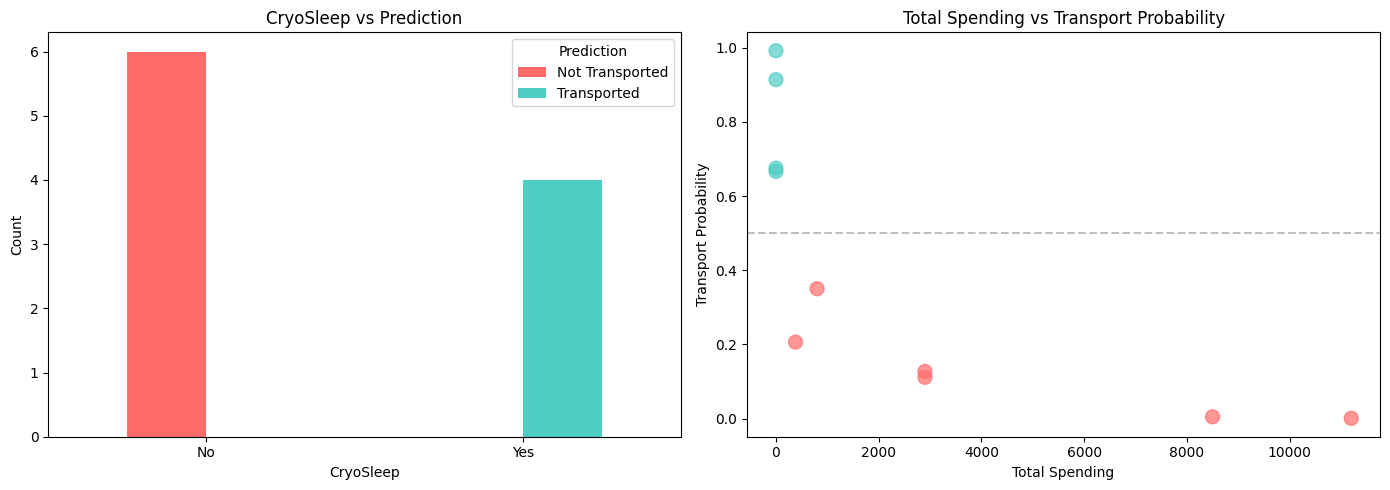

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 냉동 수면 vs 예측 결과
ax = axes[0]
cryo_transport = df_logs.groupby(['CryoSleep', 'predicted_class']).size().unstack(fill_value=0)
cryo_transport.plot(kind='bar', ax=ax, color=['#ff6b6b', '#4ecdc4'])
ax.set_xlabel('CryoSleep')
ax.set_ylabel('Count')
ax.set_title('CryoSleep vs Prediction')
ax.legend(title='Prediction')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# 총 지출 vs 이동 확률
ax = axes[1]
colors = ['#4ecdc4' if c == 'Transported' else '#ff6b6b' for c in df_logs['predicted_class']]
ax.scatter(df_logs['TotalSpending'], df_logs['probability'], c=colors, alpha=0.7, s=100)
ax.set_xlabel('Total Spending')
ax.set_ylabel('Transport Probability')
ax.set_title('Total Spending vs Transport Probability')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()